In [1]:
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from imblearn.over_sampling import SMOTE

In [2]:
teams_df = pd.read_csv("scaled_teams_itm.csv")
scaled_games_df = pd.read_csv("scaled_games.csv")

In [3]:
teams_df = teams_df[['year', 'abbrev', 'id', 'record.overall.wins', 'record.overall.losses', 'record.overall.pointsFor', 'record.overall.pointsAgainst', 'scaled_pointsFor', 'scaled_pointsAgainst', 'itm', 'playoffSeed' ]]
teams_df.rename(columns={'record.overall.wins': 'wins', 'record.overall.losses': 'losses', 'record.overall.pointsFor': 'pointsFor', 'record.overall.pointsAgainst': 'pointsAgainst'}, inplace=True)
#teams_df.set_index(['year', 'id'], inplace=True)
teams_df.head()

,year,abbrev,id,wins,losses,pointsFor,pointsAgainst,scaled_pointsFor,scaled_pointsAgainst,itm,playoffSeed
0,2020,#1,1,11,2,1899.1,1624.8,0.939520,-0.857105,NaN,1
1,2020,GUY,2,8,5,1805.0,1757.0,0.482095,0.541343,NaN,5
2,2020,Seth,3,6,7,1552.3,1714.6,-0.746294,0.092824,NaN,4
3,2020,TMB,7,7,6,1636.3,1562.1,-0.337965,-1.520362,NaN,7
4,2020,Mill,9,4,9,1586.9,1720.2,-0.578101,0.152063,NaN,10


In [4]:
with_games = teams_df.merge(scaled_games_df, left_on=['year', 'id'], right_on=['year', 'Team'])

In [5]:
with_games.head()

,year,abbrev,id,wins,losses,pointsFor,pointsAgainst,scaled_pointsFor,scaled_pointsAgainst,itm,playoffSeed,Team,lucky_win,unlucky_loss,scaled_lucky_win,scaled_unlucky_loss
0,2020,#1,1,11,2,1899.1,1624.8,0.939520,-0.857105,NaN,1,1,0,0,-1.365473,-1.893506
1,2020,GUY,2,8,5,1805.0,1757.0,0.482095,0.541343,NaN,5,2,0,1,-1.365473,-0.811503
2,2020,Seth,3,6,7,1552.3,1714.6,-0.746294,0.092824,NaN,4,3,3,2,1.526117,0.270501
3,2020,TMB,7,7,6,1636.3,1562.1,-0.337965,-1.520362,NaN,7,7,3,1,1.526117,-0.811503
4,2020,Mill,9,4,9,1586.9,1720.2,-0.578101,0.152063,NaN,10,9,2,3,0.562254,1.352504


In [6]:
just_itm = with_games.dropna()
X = just_itm[['wins', 'losses', 'scaled_pointsFor', 'scaled_pointsAgainst', 'scaled_lucky_win', 'scaled_unlucky_loss', 'playoffSeed']]
y = just_itm['itm']

sm_over = SMOTE(random_state=10)
os_X, os_y = sm_over.fit_resample(X,  y)

X_train, X_test, y_train, y_test = train_test_split(os_X, os_y, test_size = 0.20)

In [7]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=2000)
mlp.fit(X_train, y_train.values.ravel())

MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=2000)

In [8]:
cur_teams = with_games[with_games['itm'].isna()]
X_cur = cur_teams[['wins', 'losses', 'scaled_pointsFor', 'scaled_pointsAgainst', 'scaled_lucky_win', 'scaled_unlucky_loss', 'playoffSeed']]

In [9]:
predictions = mlp.predict(X_test)

In [10]:
predictions

array([1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.])

In [11]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[14  2]
 [ 2 15]]
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88        16
         1.0       0.88      0.88      0.88        17

    accuracy                           0.88        33
   macro avg       0.88      0.88      0.88        33
weighted avg       0.88      0.88      0.88        33



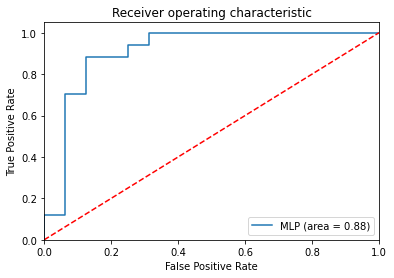

In [12]:
ml_roc_auc = roc_auc_score(y_test, mlp.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, mlp.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='MLP (area = %0.2f)' % ml_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [13]:
cur_predictions = mlp.predict(X_cur)

In [14]:
cur_teams["pred_itm"] = cur_predictions
cur_teams[['id', 'abbrev', 'wins', 'losses', 'pred_itm']].head(12)

,id,abbrev,wins,losses,pred_itm
0,1,#1,11,2,1.0
1,2,GUY,8,5,1.0
2,3,Seth,6,7,0.0
3,7,TMB,7,6,0.0
4,9,Mill,4,9,0.0
5,10,TWS,2,11,0.0
6,12,BBc,9,4,0.0
7,13,#50%,7,6,0.0
8,15,faq,10,3,1.0
9,16,JJJ,5,8,0.0


In [15]:
prob_predict = mlp.predict_proba(X_cur)
for i in range(len(X_cur)):
	print("X=%s, Predicted=%.2f" % (X_cur.values[i], prob_predict[i][1]))

X=[11.          2.          0.93952047 -0.85710456 -1.36547286 -1.89350623
  1.        ], Predicted=1.00
X=[ 8.          5.          0.48209516  0.54134312 -1.36547286 -0.81150267
  5.        ], Predicted=0.99
X=[ 6.          7.         -0.74629352  0.09282434  1.52611672  0.27050089
  4.        ], Predicted=0.00
X=[ 7.          6.         -0.33796487 -1.52036227  1.52611672 -0.81150267
  7.        ], Predicted=0.00
X=[ 4.          9.         -0.57810101  0.15206267  0.56225353  1.35250445
 10.        ], Predicted=0.00
X=[ 2.         11.         -1.62420011  0.97928361  0.56225353 -0.81150267
 11.        ], Predicted=0.00
X=[ 9.          4.          1.46354223  0.08647738 -1.36547286  0.27050089
  3.        ], Predicted=0.00
X=[ 7.          6.         -0.05359314  0.37103292 -0.40160966 -0.81150267
  8.        ], Predicted=0.17
X=[10.          3.          1.74305292 -1.57219581  0.56225353  1.35250445
  2.        ], Predicted=1.00
X=[ 5.          8.         -0.44636641  0.06955214 -0.4